In [13]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
# pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field
from skimage.transform import resize

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate

from streamtracer import StreamTracer, VectorGrid

In [2]:
b_true = np.load('/mnt/d/low_lou/test/case1.npz')['b'].astype(np.float32)
b_true.shape

(64, 64, 64, 3)

In [7]:
meta_path = Path("/home/usr/workspace/uno_pi_cc_hnorm_unit_aug_ccc_square_energy_lowlou2")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
b_bottom = b_true[:, :, 0, :]
b_bottom.shape

(64, 64, 3)

In [9]:
model_input = b_bottom
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

torch.Size([1, 1, 64, 64, 3])

In [10]:
model_output = model(model_input)
model_output.shape

torch.Size([1, 64, 64, 64, 3])

In [11]:
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi
# b = b[8:-8, 8:-8, :, :]
b.shape

(64, 64, 64, 3)

In [12]:
evaluate(b, b_true)

C_vec     : 0.9981
C_cs      : 0.9751
E_n'      : 0.9048
E_m'      : 0.8340
eps       : 0.9982
CW_sin    : 0.3123
L_f       : 0.1240
L_d       : 0.1006
l2_err    : 0.0615


{'C_vec': 0.9981094018838822,
 'C_cs': 0.9750930628427174,
 "E_n'": 0.9047551746330212,
 "E_m'": 0.8340436591152522,
 'eps': 0.99821068563295,
 'CW_sin': 0.3123187328865913,
 'L_f': 0.12402395475678948,
 'L_d': 0.10059799215715001,
 'l2_err': 0.061472072208964064}

In [34]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = b.shape[0]
Ly = b.shape[1]
numbers = 50
xyranges = [
    [0.25, 0.75, 0.25, 0.75]
]

grid_spacing = [1, 1, 1]

grid_true = VectorGrid(b_true, grid_spacing)
grid = VectorGrid(b, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)
    tracer.trace(seeds, grid_true)
    tracer_xs_true.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]
tracer_xs_true = [item for sublist in tracer_xs_true for item in sublist]

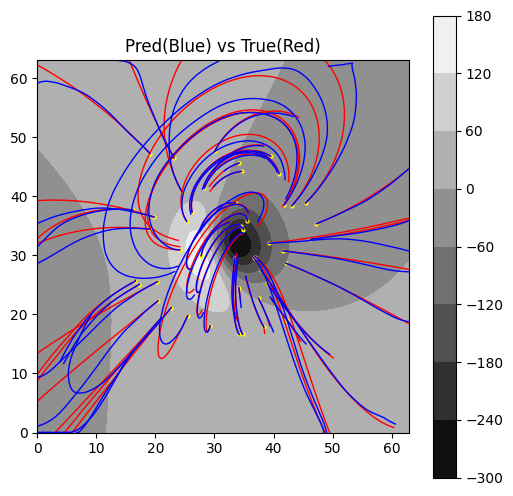

In [39]:
seedcolor = 'yellow'
seedsize = 2
linecolor_true = 'red'
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
# ax.pcolor(b_true[..., 0, 2].T, cmap='gray')
cs = ax.contourf(b_true[..., 0, 2].T, cmap='gray', alpha=1)
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor_true, linewidth=linesize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("Pred(Blue) vs True(Red)")
plt.colorbar(cs)
plt.show()